# (VAD) Velocity Azimuth Display

Argonne National Laboratory

Original code by Jonathan Helmus

In [2]:
import pyart
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np
# import warnings
# warnings.filterwarnings("ignore")
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-18 14:54:00.199150. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
def pyart_velocity_correct(norm_coh_power=None,
                           norm_coh_power_value=0.5,
                           gatefilter=None,
                           nyquist_velocity=None):
    if norm_coh_power is None:
        # Copying a field and its shape to use as a
        # norm_coherent_power array with matching shape.
        radar.add_field_like('reflectivity', 'norm_coh_power',
                             radar.fields['reflectivity']['data'].copy(),
                             replace_existing=True)
        # Setting all values to norm_coh_power_value,
        # in the field norm_coh_power.
        (radar.fields['norm_coh_power']['data'])[
            radar.fields['norm_coh_power']['data'] !=
            norm_coh_power_value] = norm_coh_power_value
        norm_coh_power_used = 'norm_coh_power'
    else:
        norm_coh_power_used = norm_coh_power
    
    if gatefilter is none:
        gatefilter = pyart.correct.GateFilter(radar)
        gatefilter.exclude_below(norm_coh_power_used, norm_coh_power_value)
    else:
        gatefilter = gatefilter

    if nyquist_velocity is None:
        nyq = None
        corr_vel = pyart.correct.dealias_region_based(
            radar, vel_field='velocity', keep_original=False,
            gatefilter=gatefilter, nyquist_vel=nyq,
            centered=False)
        radar.add_field('corrected_velocity', corr_vel,
                          replace_existing=True)
    else:
        nyq = nyquist_velocity
        corr_vel = pyart.correct.dealias_region_based(
            radar, vel_field='velocity', keep_original=False,
            gatefilter=gatefilter, nyquist_vel=nyq,
            centered=False)
        radar.add_field('corrected_velocity', corr_vel,
                          replace_existing=True)

/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-18 14:54:01.060346. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [11]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _vad_calculation
    _inverse_dist_squared
    _Average1D

"""

import numpy as np

from pyart.core import HorizontalWindProfile


def velocity_azimuth_display(
        radar, velocity, z_want=None,
        valid_ray_min=16, gatefilter=None, window=2,
        weight='equal'):
    """
    Velocity azimuth display.

    Note: If a specific sweep is desired, before using the
    velocity_azimuth_display function, use, for example:
    one_sweep_radar = radar.extract_sweeps([0])

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Array of desired heights to be sampled for the vad
        calculation.
    valid_ray_min : int
        Amount of rays required to include that level in
        the VAD calculation.
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded when
        from the vad calculation.
    window : int
        Value to use for window when determing new values in the
        _Averag1D function.
    weight : string
        A string to indicate weighting method to use. 'equal' for
        equal weighting when interpolating or 'idw' for inverse
        distribution squared weighting for interpolating.
        Default is 'equal'.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ----------
    K. A. Browning and R. Wexler, 1968: The Determination
    of Kinematic Properties of a Wind Field Using Doppler
    Radar. J. Appl. Meteor., 7, 105–113

    """

    velocities = radar.fields[velocity]['data']
    if gatefilter is not None:
        velocities = np.ma.masked_where(
            gatefilter.gate_excluded, velocities)
    azimuths = radar.azimuth['data'][:]
    elevation = radar.fixed_angle['data'][0]

    u_wind, v_wind = _vad_calculation(velocities, azimuths,
                                      elevation, valid_ray_min)
    bad = np.logical_or(np.isnan(u_wind), np.isnan(v_wind))
    good_u_wind = u_wind[~bad]
    good_v_wind = v_wind[~bad]

    radar_height = radar.gate_z['data'][0]
    good_height = radar_height[~bad]
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)
    else:
        z_want
    try:
        print('max height', np.max(good_height), ' meters')
        print('min height', np.min(good_height), ' meters')
    except ValueError:
        raise ValueError('Not enough data in this radar sweep ' \
                         'for a vad calculation.')

    u_interp = _Average1D(good_height, good_u_wind,
                          z_want[1] - z_want[0] / window, weight)
    v_interp = _Average1D(good_height, good_v_wind,
                          z_want[1] - z_want[0] / window, weight)

    u_wanted = u_interp(z_want)
    v_wanted = v_interp(z_want)
    u_wanted = np.ma.masked_equal(u_wanted, 99999.)
    v_wanted = np.ma.masked_equal(v_wanted, 99999.)

    vad = HorizontalWindProfile.from_u_and_v(
        z_want, u_wanted, v_wanted)
    return vad

def _vad calculation(velocities, azimuths,
                     elevation, valid_ray_min):
    """ Calculates VAD for a scan and returns u_mean and
    v_mean. velocities is a 2D array, azimuths is a 1D
    array, elevation is a number.

    Jonathan's Note:
    We need to solve: Ax = b
    where:
    A = [sum_sin_squared_az, sum_sin_cos_az    ] = [a, b]
        [sum_sin_cos_az,     sum_cos_squared_az]   [c, d]
    b = [sum_sin_vel_dev] = [b_1]
        [sum_cos_vel_dev]   [b_2]
    The solution to this is:
    x = A-1 * b

    A-1 is:
     1    [ d,  -b ]
    --- * [ -c,  a ]
    |A|

    and the determinate, det is: det = a*d - b*c

    Therefore the elements of x are:

    x_1 = (d* b_1  + -b * b_2) / det = (d*b_1 - b*b_2) / det
    x_2 = (-c * b_1 +  a * b_2) / det = (a*b_2 - c*b_1) / det

    """
    velocities = velocities.filled(np.nan)
    shape = velocities.shape
    _, nbins = velocities.shape

    invalid = np.isnan(velocities)
    valid_rays_per_gate = np.sum(~np.isnan(velocities), axis=0)
    too_few_valid_rays = valid_rays_per_gate < valid_ray_min
    invalid[:, too_few_valid_rays] = True

    sin_az = np.sin(np.deg2rad(azimuths))
    cos_az = np.cos(np.deg2rad(azimuths))
    sin_az = np.repeat(sin_az, nbins).reshape(shape)
    cos_az = np.repeat(cos_az, nbins).reshape(shape)
    sin_az[invalid] = np.nan
    cos_az[invalid] = np.nan

    mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)
    velocity_deviation = velocities - mean_velocity_per_gate

    sum_cos_vel_dev = np.nansum(cos_az * velocity_deviation, axis=0)
    sum_sin_vel_dev = np.nansum(sin_az * velocity_deviation, axis=0)

    sum_sin_cos_az = np.nansum(sin_az * cos_az, axis=0)
    sum_sin_squared_az = np.nansum(sin_az**2, axis=0)
    sum_cos_squared_az = np.nansum(cos_az**2, axis=0)

    # The A matrix
    a = sum_sin_squared_az
    b = sum_sin_cos_az
    c = sum_sin_cos_az
    d = sum_cos_squared_az

    # The b vector
    b_1 = sum_sin_vel_dev
    b_2 = sum_cos_vel_dev

    # solve for the x vector
    determinant = a*d - b*c
    x_1 = (d*b_1 - b*b_2) / determinant
    x_2 = (a*b_2 - c*b_1) / determinant

    # calculate horizontal components of winds
    elevation_scale = 1 / np.cos(np.deg2rad(elevation))
    u_mean = x_1 * elevation_scale
    v_mean = x_2 * elevation_scale
    return u_mean, v_mean


def _inverse_dist_squared(dist):
    """ Obtaining distance weights by using distance weighting
    interpolation, using the inverse distance-squared relationship.
    """
    weights = 1 / (dist * dist)
    weights[np.isnan(weights)] = 99999.
    return weights


class _Average1D(object):
    """ Used to find the nearest gate height and horizontal wind
    value with respect to the user's desired height. """
    def __init__(self, x, y, window, weight,
                 fill_value=99999.):
        sort_idx = np.argsort(x)
        self.x_sorted = x[sort_idx]
        self.y_sorted = y[sort_idx]
        self.window = window
        self.fill_value = fill_value

        if weight == 'equal':
            self.weight_func = lambda x: None
        elif weight == 'idw':
            self.weight_func = _inverse_dist_squared
        elif callable(weight):
            self.weight_func = weight
        else:
            raise ValueError("Invalid weight argument:", weight)

    def __call__(self, x_new, window=None):
        if window is None:
            window = self.window
        y_new = np.zeros_like(x_new, dtype=self.y_sorted.dtype)
        for i, center in enumerate(x_new):

            bottom = center - window
            top = center + window
            start = np.searchsorted(self.x_sorted, bottom)
            stop = np.searchsorted(self.x_sorted, top)

            x_in_window = self.x_sorted[start:stop]
            y_in_window = self.y_sorted[start:stop]
            if len(x_in_window) == 0:
                y_new[i] = self.fill_value
            else:
                distances = x_in_window - center
                weights = self.weight_func(distances)
                y_new[i] = np.average(y_in_window, weights=weights)
        return y_new

/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-18 15:29:14.960374. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [12]:
filename = '/home/zsherman/training_exercises/data/KLOT20130417_235520_V06.gz'
myradar = pyart.io.read(filename)

/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-18 15:29:17.260967. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [146]:
myradar.sweep_start_ray_index['data']

array([   0,  720, 1440, 2160, 2880, 3600, 4320, 4680, 5040, 5400, 5760,
       6120, 6480, 6840, 7200, 7560, 7920], dtype=int32)

/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-07 14:53:44.999927. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
velocities = myradar.fields['velocity']['data'][:, :]
azimuths = myradar.azimuth['data'][:]
elevation = myradar.fixed_angle['data'][0]

u_wind, v_wind = _vad_calculation(velocities, azimuths,
                                  elevation, 16)

In [206]:
gatefilter = pyart.correct.GateFilter(myradar)
velocities = myradar.fields[
    'velocity']['data'][:, :]
#velocities = velocities.filled(np.nan)
shape = velocities.shape
_, nbins = velocities.shape
#velocities = np.ma.masked_invalid(velocities)

azimuths = myradar.azimuth['data'][:]
elevation = myradar.fixed_angle['data'][0]
invalid = np.ma.getmaskarray(velocities)
valid_rays_per_gate = np.sum(~ma.getmaskarray(velocities),
                             axis=0)
too_few_valid_rays = valid_rays_per_gate < 16
invalid[:, too_few_valid_rays] = True

gatefilter.exclude_gates(invalid)

In [207]:
sin_az = np.sin(np.deg2rad(azimuths))
cos_az = np.cos(np.deg2rad(azimuths))
sin_az = np.repeat(sin_az, nbins).reshape(shape)
cos_az = np.repeat(cos_az, nbins).reshape(shape)
sin_az[invalid] = np.nan
cos_az[invalid] = np.nan

sin_az = np.ma.masked_invalid(sin_az)
cos_az = np.ma.masked_invalid(cos_az)

mean_velocity_per_gate = ma.mean(velocities, axis=0).reshape(1, -1)
velocity_deviation = velocities - mean_velocity_per_gate

sum_cos_vel_dev = ma.sum(cos_az * velocity_deviation, axis=0)
sum_sin_vel_dev = ma.sum(sin_az * velocity_deviation, axis=0)

sum_sin_cos_az = ma.sum(sin_az * cos_az, axis=0)
sum_sin_squared_az = ma.sum(sin_az**2, axis=0)
sum_cos_squared_az = ma.sum(cos_az**2, axis=0)

# The A matrix
a = sum_sin_squared_az
b = sum_sin_cos_az
c = sum_sin_cos_az
d = sum_cos_squared_az

# The b vector
b_1 = sum_sin_vel_dev
b_2 = sum_cos_vel_dev

# solve for the x vector
determinant = a*d - b*c
x_1 = (d*b_1 - b*b_2) / determinant
x_2 = (a*b_2 - c*b_1) / determinant

# calculate horizontal components of winds
elevation_scale = 1 / np.cos(np.deg2rad(elevation))
u_mean = x_1 * elevation_scale
v_mean = x_2 * elevation_scale

In [208]:
u_mean.mean()  

7.4338383120712637

In [ ]:
z = myradar.gate_z['data'][0]

In [210]:
z = np.ma.masked_where(u_mean.mask, z)

In [211]:
z.mean()

2779.4054991734856

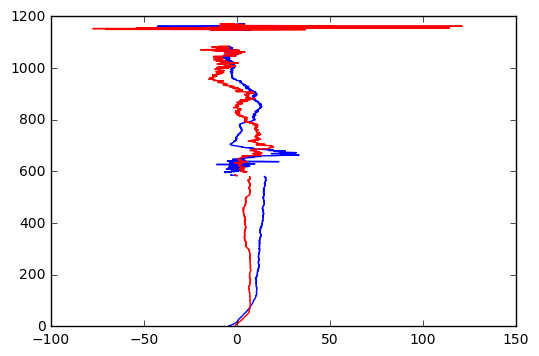

In [268]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(u_mean, np.arange(0, 1832), 'b-')
ax.plot(v_mean, np.arange(0, 1832), 'r-')

plt.show()

In [234]:
radar_sweep = myradar.extract_sweeps([3])

In [244]:
velocities = myradar.fields[
    'velocity']['data'][:, :]
azimuths = myradar.azimuth['data'][:]
elevation = myradar.fixed_angle['data'][0]
velocities = velocities.filled(np.nan)
shape = velocities.shape
_, nbins = velocities.shape

invalid = np.isnan(velocities)
valid_rays_per_gate = np.sum(~np.isnan(velocities), axis=0)
too_few_valid_rays = valid_rays_per_gate < 16
invalid[:, too_few_valid_rays] = True

sin_az = np.sin(np.deg2rad(azimuths))
cos_az = np.cos(np.deg2rad(azimuths))
sin_az = np.repeat(sin_az, nbins).reshape(shape)
cos_az = np.repeat(cos_az, nbins).reshape(shape)
sin_az[invalid] = np.nan
cos_az[invalid] = np.nan

mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)
velocity_deviation = velocities - mean_velocity_per_gate

sum_cos_vel_dev = np.nansum(cos_az * velocity_deviation, axis=0)
sum_sin_vel_dev = np.nansum(sin_az * velocity_deviation, axis=0)

sum_sin_cos_az = np.nansum(sin_az * cos_az, axis=0)
sum_sin_squared_az = np.nansum(sin_az**2, axis=0)
sum_cos_squared_az = np.nansum(cos_az**2, axis=0)

# The A matrix
a = sum_sin_squared_az
b = sum_sin_cos_az
c = sum_sin_cos_az
d = sum_cos_squared_az

# The b vector
b_1 = sum_sin_vel_dev
b_2 = sum_cos_vel_dev

# solve for the x vector
determinant = a*d - b*c
x_1 = (d*b_1 - b*b_2) / determinant
x_2 = (a*b_2 - c*b_1) / determinant

# calculate horizontal components of winds
elevation_scale = 1 / np.cos(np.deg2rad(elevation))
u_mean = x_1 * elevation_scale
v_mean = x_2 * elevation_scale

/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in true_divide


In [245]:
u_mean

array([-4.83624914, -4.67340984, -4.28149315, ...,         nan,
               nan,         nan])

In [304]:
height = myradar.gate_z['data'][0]
bad = np.logical_or(np.isnan(u_mean), np.isnan(v_mean))

good_u_wind = u_mean[~bad]
good_v_wind = v_mean[~bad]
good_height = height[~bad]
print('max height', np.max(height), ' meters')
print('min height', np.min(height), ' meters')
u_mean.shape

max height 16378.3196353  meters
min height 18.4995460641  meters


(1832,)

In [307]:
myradar.azimuth['data'].shape

(8280,)

In [285]:
myradar.gate_z['data'][0].shape

(1832,)

In [282]:
u_mean.shape

(1832,)

In [251]:
myradar.azimuth['data'].shape

(8280,)

In [150]:
good_u_wind.mean()

7.4338383114325026

In [345]:
np.diff(myradar.time['data'][719:721])

array([ 0.765])

In [329]:
t = myradar.time['data']

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

ax2.plot(u_mean, np.arange(0, 1832), 'b-')

plt.show()

max height: 707.136208968
max height 707.136208968  meters
min height 0.0  meters


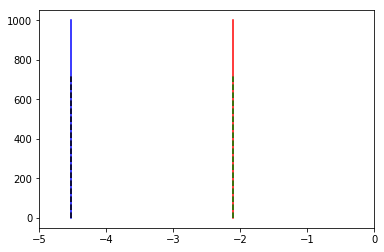

Height
[  0.         10.1010101  20.2020202  30.3030303  40.4040404]
[  0.         10.1010101  20.2020202  30.3030303  40.4040404]
[  959.5959596   969.6969697   979.7979798   989.8989899  1000.       ]
[  959.5959596   969.6969697   979.7979798   989.8989899  1000.       ]
u_wind:
[-2.11309131 -2.11309131 -2.11309131 -2.11309131 -2.11309131]
[-2.113091255279754 -2.113091255279754 -2.113091255279754
 -2.113091255279754 -2.113091255279754]
[-2.11309131 -2.11309131 -2.11309131 -2.11309131 -2.11309131]
[-- -- -- -- --]
v_wind:
[-4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.5315

/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-18 15:44:11.191814. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
import numpy as np

# create a profile of 100 heights up to 500 m with 5 m/s winds at 25 degrees
height = np.linspace(0, 1000, 100)
speed = np.ones_like(height) * 5
direction = np.ones_like(height) * 25
profile = pyart.core.HorizontalWindProfile(height, speed, direction)

# simulate a single sweep radar with a velocity field from the profile
test_radar = pyart.testing.make_target_radar()
test_radar.elevation['data'][:] = 45.0
test_radar.fixed_angle['data'][:] = 45.0
print("max height:", test_radar.gate_z['data'].max())
sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
test_radar.add_field('velocity', sim_vel, replace_existing=True)

# perform a VAD retrieval
vad_test = velocity_azimuth_display(
    test_radar, 'velocity', valid_ray_min=16,
    height=height, window=2,
    gatefilter=None)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(profile.u_wind, profile.height, 'r-')
ax.plot(profile.v_wind, profile.height, 'b-')

ax.plot(vad_test.u_wind, vad_test.height, 'g--')
ax.plot(vad_test.v_wind, vad_test.height, 'k--')

ax.set_xlim(-5, 0)
plt.show()
# print out the results
print("Height")
print(profile.height[:5])
print(vad_test.height[:5])
print(profile.height[-5:])
print(vad_test.height[-5:])

print("u_wind:")
print(profile.u_wind[:5])
print(vad_test.u_wind[:5])
print(profile.u_wind[-5:])
print(vad_test.u_wind[-5:])

print("v_wind:")
print(profile.v_wind)
print(vad_test.v_wind)
#print(profile.v_wind[-5:])
#print(vad_test.v_wind[-5:])

print("speed:")
print(profile.speed[:5])
print(vad_test.speed[:5])
print(vad_test.speed[-5:])
print("direction:")
print(profile.direction[:5])
print(vad_test.direction[:5])
print(vad_test.direction[-5:])

In [42]:
test_radar = pyart.io.read(pyart.testing.NEXRAD_ARCHIVE_MSG1_FILE)
new_radar = test_radar.extract_sweeps([4])
radar_sweep = myradar.extract_sweeps([5])
height = np.linspace(50, 10766, 101)
valid_ray_min = 16
window = 2

print("max height:", new_radar.gate_z['data'][0].max())

# perform a VAD retrieval
vad_test = velocity_azimuth_display(
    radar_sweep, 'velocity', height=height, gatefilter=None,
    valid_ray_min=valid_ray_min)
# print out the results
print("Height")
print(vad_test.height)


print("u_wind:")
print(vad_test.u_wind)

print("v_wind:")
print(vad_test.v_wind)

print("speed:")
print(vad_test.speed)

print("direction:")
print(vad_test.direction)

/home/zsherman/.local/lib/python3.5/site-packages/pyart/io/nexrad_archive.py:207: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 4, 5, 6] for moment REF.
  UserWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


max height: 32085.2190865
max height 9837.16932286  meters
min height 50.7863716818  meters
Height
[    50.      157.16    264.32    371.48    478.64    585.8     692.96
    800.12    907.28   1014.44   1121.6    1228.76   1335.92   1443.08
   1550.24   1657.4    1764.56   1871.72   1978.88   2086.04   2193.2
   2300.36   2407.52   2514.68   2621.84   2729.     2836.16   2943.32
   3050.48   3157.64   3264.8    3371.96   3479.12   3586.28   3693.44
   3800.6    3907.76   4014.92   4122.08   4229.24   4336.4    4443.56
   4550.72   4657.88   4765.04   4872.2    4979.36   5086.52   5193.68
   5300.84   5408.     5515.16   5622.32   5729.48   5836.64   5943.8
   6050.96   6158.12   6265.28   6372.44   6479.6    6586.76   6693.92
   6801.08   6908.24   7015.4    7122.56   7229.72   7336.88   7444.04
   7551.2    7658.36   7765.52   7872.68   7979.84   8087.     8194.16
   8301.32   8408.48   8515.64   8622.8    8729.96   8837.12   8944.28
   9051.44   9158.6    9265.76   9372.92   9480.08 

/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:199: RuntimeWarning: invalid value encountered in true_divide
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:200: RuntimeWarning: invalid value encountered in true_divide
/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-27 11:23:54.851043. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


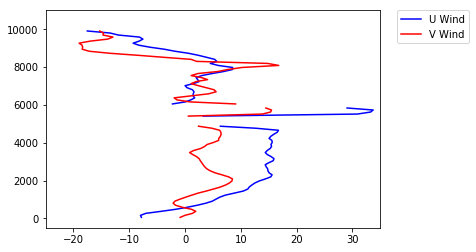

/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-27 10:38:39.738851. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(vad_test.u_wind, vad_test.height, 'b-', label='U Wind')
plt.plot(vad_test.v_wind, vad_test.height, 'r-', label='V Wind')
plt.xlim(-25, 35)
plt.ylim(-500, 11000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

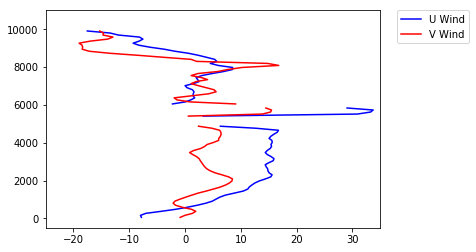

/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-07 15:04:15.708301. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [158]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(vad_test.u_wind, vad_test.height, 'b-', label='U Wind')
plt.plot(vad_test.v_wind, vad_test.height, 'r-', label='V Wind')
plt.xlim(-25, 35)
plt.ylim(-500, 11000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [91]:
test_radar.fields

{'reflectivity': {'_FillValue': -9999.0,
  'coordinates': 'elevation azimuth range',
  'data': masked_array(data =
   [[-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]
   ..., 
   [-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]],
               mask =
   [[ True  True  True ...,  True  True  True]
   [ True  True  True ...,  True  True  True]
   [ True  True  True ...,  True  True  True]
   ..., 
   [ True  True  True ...,  True  True  True]
   [ True  True  True ...,  True  True  True]
   [ True  True  True ...,  True  True  True]],
         fill_value = 1e+20),
  'long_name': 'Reflectivity',
  'standard_name': 'equivalent_reflectivity_factor',
  'units': 'dBZ',
  'valid_max': 94.5,
  'valid_min': -32.0},
 'spectrum_width': {'_FillValue': -9999.0,
  'coordinates': 'elevation azimuth range',
  'data': masked_array(data =
   [[-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]
   [-- -- -- ..., -- -- --]
   ..., 
   [-- -

/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-06 10:44:26.083968. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [82]:
corr_vel = pyart.correct.dealias_region_based(
    test_radar, vel_field='velocity', gatefilter=None,
    nyquist_vel=nyq)
test_radar.add_field('corrected_velocity', corr_vel,
                        replace_existing=True)

test_radar.fields['velocity']['data']

masked_array(data =
 [[-3.2042818554399934 -3.2042818554399934 -3.2042818554399934 ...,
  -3.2042818554399934 -3.2042818554399934 -3.2042818554399934]
 [-3.2298709318138203 -3.2298709318138203 -3.2298709318138203 ...,
  -3.2298709318138203 -3.2298709318138203 -3.2298709318138203]
 [-3.2544761058188496 -3.2544761058188496 -3.2544761058188496 ...,
  -3.2544761058188496 -3.2544761058188496 -3.2544761058188496]
 ..., 
 [-3.121691010680604 -3.121691010680604 -3.121691010680604 ...,
  -3.121691010680604 -3.121691010680604 -3.121691010680604]
 [-3.1501836119348496 -3.1501836119348496 -3.1501836119348496 ...,
  -3.1501836119348496 -3.1501836119348496 -3.1501836119348496]
 [-3.177716516387311 -3.177716516387311 -3.177716516387311 ...,
  -3.177716516387311 -3.177716516387311 -3.177716516387311]],
             mask =
 [[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False

In [84]:
np.ma.array(test_radar.fields['corrected_velocity']['data'])

masked_array(data =
 [[-3.20428186 -3.20428186 -3.20428186 ..., -3.20428186 -3.20428186
  -3.20428186]
 [-3.22987093 -3.22987093 -3.22987093 ..., -3.22987093 -3.22987093
  -3.22987093]
 [-3.25447611 -3.25447611 -3.25447611 ..., -3.25447611 -3.25447611
  -3.25447611]
 ..., 
 [-3.12169101 -3.12169101 -3.12169101 ..., -3.12169101 -3.12169101
  -3.12169101]
 [-3.15018361 -3.15018361 -3.15018361 ..., -3.15018361 -3.15018361
  -3.15018361]
 [-3.17771652 -3.17771652 -3.17771652 ..., -3.17771652 -3.17771652
  -3.17771652]],
             mask =
 False,
       fill_value = 1e+20)

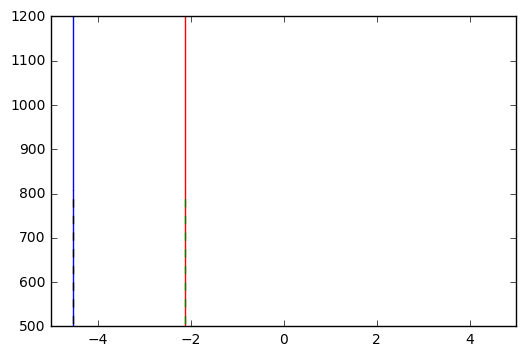

In [277]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(profile.u_wind, profile.height, 'r-')
ax.plot(profile.v_wind, profile.height, 'b-')

ax.plot(vad_test.u_wind, vad_test.height, 'g--')
ax.plot(vad_test.v_wind, vad_test.height, 'k--')

ax.set_xlim(-5, 5)
ax.set_ylim(500, 1200)
plt.show()

In [272]:
new_radar = myradar.extract_sweeps([1])

In [273]:
new_radar.gate_z['data'][0]

array([    19.82374755,     22.19089841,     24.56540615, ...,
        16632.7430889 ,  16648.53628052,  16664.33678599])

In [301]:
height_klot = np.linspace(0, 10000, 1832)

In [302]:
vad_klot = velocity_azimuth_display(
    new_radar, 'velocity', height=height_klot, gatefilter=True,
    window=2)

max height 6400.87383943  meters
min height 0.0  meters


/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:192: RuntimeWarning: invalid value encountered in true_divide
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:193: RuntimeWarning: invalid value encountered in true_divide


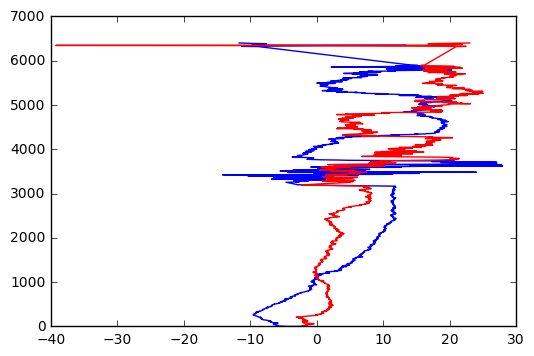

In [291]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(vad_klot.u_wind, vad_klot.height, 'b-')
ax.plot(vad_klot.v_wind, vad_klot.height, 'r-')

plt.show()

In [402]:
vad_klot.u_wind

masked_array(data = [-0.5835666690848077 1.5688490941195001 5.3980771288773 8.440683315121735
 10.62681108978826 11.721623417519194 11.886895774656093 12.022555117842657
 12.653761506741066 13.29858516430744 13.743307893120193 14.020977332744097
 14.459731624046272 15.106732324802387 15.58986351586532 15.846898130258946
 15.864099912299425 15.60166797893651 15.32647962855722 15.182550978567287
 15.159838586822495 15.360259738826421 15.712305754306334
 15.913254229755136 16.028501574058676 16.136743879729973
 16.154277936685176 16.10239841093096 16.13196581214299 16.25035689059055
 16.42516356065864 16.70259618339238 15.28679863799207 9.280921912526699
 -2.1356647143864307 -0.6818046984584752 2.676917140765899
 7.044928761067773 7.001719871383886 8.897916561170375 19.644442583053927
 23.71349487532522 13.379192508519443 2.651557533876936 -2.1441282543564997
 -2.354976131367514 -1.4809911472947628 -0.31434562829349977
 1.4821702552471643 2.954200226756123 3.084883624900796 3.115904284762

In [863]:
dir(myradar)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_sweep_in_range',
 '_dic_info',
 'add_field',
 'add_field_like',
 'altitude',
 'altitude_agl',
 'antenna_transition',
 'azimuth',
 'check_field_exists',
 'drift',
 'elevation',
 'extract_sweeps',
 'fields',
 'fixed_angle',
 'gate_altitude',
 'gate_latitude',
 'gate_longitude',
 'gate_x',
 'gate_y',
 'gate_z',
 'georefs_applied',
 'get_azimuth',
 'get_elevation',
 'get_end',
 'get_field',
 'get_gate_x_y_z',
 'get_nyquist_vel',
 'get_slice',
 'get_start',
 'get_start_end',
 'heading',
 'info',
 'init_gate_altitude',
 'init_gate_longitude_latitude',
 'init_gate_x_y_z',
 'init_rays_per_sweep',
 'instrument_

In [403]:
vad_klot.direction

masked_array(data = [156.67195572644277 204.86790082221364 220.96113765437406
 228.97038351906164 234.1373218514479 235.7449839562958 234.8247961546824
 234.61137823167124 235.61071966211566 236.3229395786536 237.19640510307667
 237.71127411209267 238.92773700617155 240.8910057959418 241.79509338848254
 242.5614337770021 243.81481788658192 243.7537028634779 243.6620765433736
 244.46499960459397 245.6066550501285 247.18097003240683 248.95078892239954
 249.61193197651593 249.12559761564012 248.3000061768567 246.08780828289449
 243.27417040804704 242.0439282939391 242.61235241283848 243.6668169844212
 244.49439912186534 244.82347655071345 239.74365388071925
 139.06984795173187 166.8827694159035 228.29530080236412 245.62681778068907
 244.51109705135616 245.50268879096245 247.50838232036386
 246.29653886148094 225.6289967583278 189.6372266722952 171.52045179408807
 170.00912729801405 173.93305941886084 178.758788513402 185.95776673102418
 191.66062393831672 191.74338080933097 191.6397215149

In [404]:
vad_klot.speed

masked_array(data = [1.4736718026513593 3.7306686594710388 8.234462700390843 11.18904423103873
 13.112665255728164 14.181548007614124 14.542425807463907
 14.747207649776213 15.333818856981884 15.980492085351058
 16.350713430314055 16.585669857145554 16.8820128073323 17.290607494726636
 17.690364678826356 17.855550818920552 17.67838831462572 17.39507744027123
 17.101762836312716 16.826087375271047 16.645780115430036
 16.664518385184042 16.835714575131778 16.9767715518876 17.15445556569926
 17.367535787490727 17.671021928475955 18.028394524248828 18.26314158854068
 18.301711981169568 18.32695796115758 18.506146030694833 16.891463393498416
 10.744547360595812 3.2598675513123765 3.004283406599308 3.5855556823271537
 7.734226898257658 7.756688880618761 9.77813733954353 21.261703219153627
 25.89832098347672 18.716694386675904 15.838766957163081 14.54076371437038
 13.574030570890127 14.012551744459357 14.511698290445597 14.27973474033196
 14.616484100948895 15.156999847914673 15.4438484431768

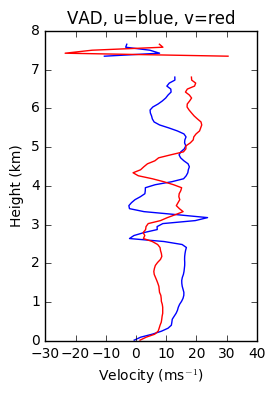

In [405]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vad_klot.u_wind, vad_klot.height / 1000.0, 'b-')
plt.plot(vad_klot.v_wind, vad_klot.height / 1000.0, 'r-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.show()

In [397]:
vad_klot.height

array([   18.49954606,    95.64170572,   172.78386538,   249.92602504,
         327.0681847 ,   404.21034436,   481.35250402,   558.49466368,
         635.63682334,   712.778983  ,   789.92114265,   867.06330231,
         944.20546197,  1021.34762163,  1098.48978129,  1175.63194095,
        1252.77410061,  1329.91626027,  1407.05841993,  1484.20057959,
        1561.34273925,  1638.4848989 ,  1715.62705856,  1792.76921822,
        1869.91137788,  1947.05353754,  2024.1956972 ,  2101.33785686,
        2178.48001652,  2255.62217618,  2332.76433584,  2409.9064955 ,
        2487.04865515,  2564.19081481,  2641.33297447,  2718.47513413,
        2795.61729379,  2872.75945345,  2949.90161311,  3027.04377277,
        3104.18593243,  3181.32809209,  3258.47025175,  3335.6124114 ,
        3412.75457106,  3489.89673072,  3567.03889038,  3644.18105004,
        3721.3232097 ,  3798.46536936,  3875.60752902,  3952.74968868,
        4029.89184834,  4107.034008  ,  4184.17616765,  4261.31832731,
      

In [ ]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vad.u_wind, vad.height / 1000.0, 'b-')
plt.plot(vad.v_wind, vad.height / 1000.0, 'r-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.xlim(-10, 25)
plt.show()

In [ ]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vad_corrected.u_wind, vad_corrected.height / 1000.0, 'b-')
plt.plot(vad_corrected.v_wind, vad_corrected.height / 1000.0, 'r-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.xlim(-10, 25)
plt.show()

In [ ]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vad_corrected.u_wind, vad_corrected.height / 1000.0, 'b-')
plt.plot(vad_corrected.v_wind, vad_corrected.height / 1000.0, 'r-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.xlim(-10, 25)
plt.show()

In [ ]:
test_radar = pyart.testing.make_target_radar()
height = np.arange(0, 1000, 200)
speed = np.ones_like(height) * 5
direction = np.array([0, 90, 180, 270, 45])
profile = pyart.core.HorizontalWindProfile(height, speed, direction)
sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
test_radar.add_field('velocity', sim_vel,
                replace_existing=True)
velocity = 'velocity'
z_start = 0
z_end = 10
z_count = 5

vad2 = velocity_azimuth_display(test_radar,
                                   velocity,
                                   z_start, z_end,
                                   z_count)

In [ ]:
profile.direction

In [ ]:
vad2.height

In [ ]:
vad2.speed

In [ ]:
vad2.direction

In [ ]:
vad2.u_wind

In [ ]:
vad2.v_wind

In [ ]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vad2.u_wind, vad2.height / 1000.0, 'b-')
plt.plot(vad2.v_wind, vad2.height / 1000.0, 'r-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x1 = vad.u_wind
x2 = vad.v_wind
y = vad.height / 1000
plt.xlim(-15, 15)
plt.ylim(-15, 15)
ax.title.set_position([.5, 1.05])
ax.set_title('Velocity Azimuth Display (VAD)')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Velocity (m/s)')
ax.set_zlabel('Height (km)')
ax.plot(x1, np.zeros_like(x1), y, label='U Mean')
ax.plot(np.zeros_like(x2), x2, y, '-r', label='V Mean')
# default ax.azim = 300, default ax.elev = 30
ax.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x1 = vad['u_mean']
x2 = vad['v_mean']
y = vad['z_interval']/1000
plt.xlim(-12, 12)
plt.ylim(-12, 12)
ax.title.set_position([.5, 1.05])
ax.set_title('Velocity Azimuth Display (VAD)')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Velocity (m/s)')
ax.set_zlabel('Height (km)')
ax.plot(x1, np.zeros_like(x1), y, label='U Mean')
ax.plot(np.zeros_like(x2), x2, y, '-r', label='V Mean')
ax.azim = 45
ax.elev = 50
ax.legend()
plt.show()

In [ ]:
    # Setting parameters for the pcolormesh plots.
    def polar_plot(self, field, sweep=0, ax=None, **kwargs):
        """
        Creates a polar plot.

        Parameters
        ----------
        radar : Radar
            Radar object Used.
        field : str
            Field to plot.

        Other Parameters
        ----------------
        vmin : float
            Luminance minimum value, None for default value.
            Parameter is ignored is norm is not None.
        vmax : float
            Luminance maximum value, None for default value.
            Parameter is ignored is norm is not None.
        title : str
            Title to label plot with, None to use default title generated from
            the field and tilt parameters. Parameter is ignored if title_flag
            is False.
        title_flag : bool
            True to add a title to the plot, False does not add a title.
        """

        ax.cla()
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        i_s = radar.sweep_start_ray_index['data'][sweep]
        i_e = radar.sweep_end_ray_index['data'][sweep]
        order = np.argsort(radar.azimuth['data'][i_s:i_e])
        # rectangular plot of polar data
        theta, rad = np.meshgrid(radar.azimuth['data'][i_s:i_e][order],
                                 radar.range['data'])
        X = theta * np.pi / 180.0
        Y = rad / 1000.0
        if 'mask' in kwargs.keys():
            pcolor = ax.pcolormesh(
                X, Y, np.ma.masked_where(
                    kwargs['mask'][
                        i_s:i_e, :][
                        order, :].transpose(), radar.fields[var]['data'][
                        i_s:i_e, :][
                            order, :].transpose()), vmin=kwargs.get(
                                'vmin', -6), vmax=kwargs.get(
                                    'vmax', 64))
        else:
            pcolor = ax.pcolormesh(
                X, Y,
                radar.fields[field]['data'][i_s:i_e, :][order, :].transpose(),
                vmin=kwargs.get('vmin', -6),
                vmax=kwargs.get('vmax', 64))

        ax.set_title(radar.metadata['instrument_name']
                     + ' ' + str(datetimes) + ' ' + field, y=1.08)

        if 'ylim' in kwargs:
            ylim(kwargs['ylim'])
        plt.grid(True)
        return pcolor

In [ ]:
# Pcolormesh of reflectivity and the number of gates a specific dBZ occurs.
good = np.where(np.logical_not(is_bad[:, 0:-20].flatten()))[0]
H, xedges, yedges = np.histogram2d(
    z[:, 0:-20].flatten()[good] / 1000.0,
    myradar.fields['reflectivity']['data'][:, 0:-20].flatten()[good],
    bins=(62, 60), range=([0, 12], [-10, 64]))

fig = plt.figure(figsize=[8, 5])
plt.pcolormesh(yedges, xedges, H)
plt.xlabel('Refl fac (dBZ)')
plt.ylabel('height (km)')
color_bar = plt.colorbar()
color_bar.set_label('ngates')
plt.xlim(-10, 64)
plt.title('CFAD of Reflectivity Factor')
plt.savefig('/home/zsherman/VAD/images/cfad_z_'
            + str(datetimes) + '.png', dpi=200,)
plt.show()

In [ ]:
# Below is some code from Susan Rennie (based off Michelson et al 2000)
# from the Centre for Australian Weather and Climate Research (CAWCR)
# for calculating VADs. I used her one tilt version and wrote my own adaptation
# into Py-ART PyRadar object.. Note I convert to U and V before averaging..
# my concern is that if you have θ rapidly varying between 360∘ and 0∘
# this will average to a nonsense number.

In [ ]:
# Location of each gate in a Cartesian coordinate system 
# assuming a standard atmosphere with a 4/3 Earth’s radius model.
x = radar.gate_x['data']
y = radar.gate_y['data']
z = radar.gate_z['data']

In [ ]:
print(np.max(myradar.gate_z['data']))
print(myradar.gate_z['units'])

In [ ]:
gatefilter = pyart.correct.GateFilter(myradar)
mask = gatefilter.exclude_below('cross_correlation_coefficient', 0.8)

In [ ]:
print(myradar.fixed_angle)

In [ ]:
is_bad = np.logical_or(
    myradar.fields['norm_coh_power']['data'] < 0.5,
    myradar.fields['cross_correlation_coefficient']['data'] < 0.8)

In [ ]:
# Pcolormesh of reflectivity
fig = plt.figure()
ax = fig.add_axes([0.0, 0.0, .9, .9], polar=True)
pcolor = polar_plot(myradar, 1, ax, 'reflectivity', mask=is_bad)
color_bar = plt.colorbar(mappable=pcolor, pad=0.10)
color_bar.set_label('Eq Refl factor (dBZ)')
plt.savefig('/home/zsherman/VAD/images/csapr_dbz_ppi.'
            + str(datetimes) + '.png', dpi=400,  bbox_inches='tight')

In [ ]:
# Pcolormesh of corrected mean doppler velocity.
fig = plt.figure()
ax = fig.add_axes([0.0, 0.0, .9, .9], polar=True)
pcolor = polar_plot(myradar, 1, ax, 'CVD',
                    mask=is_bad, vmin=-20, vmax=20)
color_bar = plt.colorbar(mappable=pcolor, pad=0.10)
color_bar.set_label(r'Mean Doppler Velocity (ms$^{-1}$, +out)')
plt.savefig('/home/zsherman/VAD/images/csapr_vel_ppi.'
            + str(datetimes) + '.png', dpi=400,  bbox_inches='tight')

In [ ]:
z_want = np.linspace(500, 10500, 101)
u_mean, v_mean = VAD(myradar, z_want)

In [ ]:
# pyart.core.HorizontalWindProfile(height, speed, direction,
                                 # latitude=None, longitude=None)

In [ ]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(u_mean, z_want / 1000.0, 'r-')
plt.plot(v_mean, z_want / 1000.0, 'b-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.show()

In [ ]:
ylims = [0, 10]
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.1, .3, .8])
plt.plot(u_mean, z_want / 1000.0, 'r-')
plt.plot(v_mean, z_want / 1000.0, 'b-')
plt.ylim(ylims)
# ax1.xaxis.set_major_locator(MaxNLocator(prune='upper'))
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
ax2 = fig.add_axes([0.4, 0.1, .5, .8])
plt.pcolormesh(yedges, xedges, H)
plt.ylim(ylims)
plt.xlim([-10, 40])
ax2.xaxis.set_major_locator(plt.MaxNLocator(prune='lower'))
ax2.get_yaxis().set_visible(False)
plt.xlabel('Refl fac (dBZ)')
color_bar = plt.colorbar()
color_bar.set_label('ngates')
plt.title('CFAD of Reflectivity Factor')
# fig.text(.3,.96,time_str)
plt.savefig('/home/zsherman/VAD/images/combo_'
            + str(datetimes) + '.png', dpi=200,  bbox_inches='tight')
plt.show()

In [ ]:
ylims = [0, 10]
fig = plt.figure(figsize=[10, 10])
ax1 = fig.add_axes([0.1, 0.5, .3, .3])
plt.plot(u_mean, z_want / 1000.0, 'r-')
plt.plot(v_mean, z_want / 1000.0, 'b-')
plt.ylim(ylims)
# ax1.xaxis.set_major_locator(MaxNLocator(prune='upper'))
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
ax2 = fig.add_axes([0.4, 0.5, .5, .3])
plt.pcolormesh(yedges, xedges, H)
plt.ylim(ylims)
plt.xlim([-10, 40])
ax2.xaxis.set_major_locator(plt.MaxNLocator(prune='lower'))
ax2.get_yaxis().set_visible(False)
plt.xlabel('Refl fac (dBZ)')
color_bar = plt.colorbar()
color_bar.set_label('ngates')
plt.title('CFAD of Reflectivity Factor')
# fig.text(.3,.96,time_str)

ax3 = fig.add_axes([0.05, 0.05, .4, .4], polar=True)
pc = polar_plot(myradar, 1, ax3, 'reflectivity', mask=is_bad)
color_bar = plt.colorbar(mappable=pc, pad=0.10)
color_bar.set_label('Eq Refl factor (dBZ)')
plt.savefig('/home/zsherman/VAD/images/csapr_dbz_ppi.'
            + str(datetimes) + '.png', dpi=400,  bbox_inches='tight')

ax4 = fig.add_axes([0.5, 0.05, .4, .4], polar=True)
pc = polar_plot(myradar, 1, ax4, 'CVD', mask=is_bad, vmin=-20, vmax=20)
color_bar = plt.colorbar(mappable=pc, pad=0.10)
color_bar.set_label(r'Mean Doppler Velocity (ms$^{-1}$, +out)')
plt.savefig('/home/zsherman/VAD/images/super_combo_' + str(datetimes)
            + '.png', dpi=200,  bbox_inches='tight')

In [855]:
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

In [913]:
vel = np.asanyarray([myradar.fields['velocity']['data'][0]])

In [966]:
vel.shape

array([[ -2.,   0.,  -1., ..., -64., -64., -64.]], dtype=float32)

In [943]:
new_vel = np.argwhere(np.isfinite(vel))
bad_vel = np.argwhere(vel > -5)

In [948]:
new_vel

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ..., 
       [   0, 1829],
       [   0, 1830],
       [   0, 1831]])

In [965]:
for i in vel[:, i]:
    if vel[:, i] == bad_vel[:, i].T:
        print('bad')

IndexError: index -64 is out of bounds for axis 1 with size 2

In [946]:
bad_vel

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4]])

In [938]:
sort_idx = new_vel.argsort()

In [939]:
sort_idx[np.searchsorted(new_vel, bad_vel, sorter=sort_idx)]

ValueError: object too deep for desired array

In [853]:
import wradlib as wrl
import numpy as np 

In [854]:
sitecoords = (-28.0069, 39.05250, 30.0)
nrays = 990
nbins = 1073
el = np.deg2rad(0.48)
bw = 0.91
range_res = 100

In [856]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
lon, lat, alt = wrl.georef.polar2lonlatalt_n(
    coord[..., 0], np.degrees(coord[..., 1]),
    coord[..., 2], sitecoords)

In [857]:
polcoords = np.dstack((lon, lat))
print("lon,lat,alt:", lon.shape, lat.shape, alt.shape)

lon,lat,alt: (990, 1073) (990, 1073) (990, 1073)


In [858]:
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" %
      (lat.max(), lon.min(), lon.max(), lat.min()))

Radar bounding box:
	40.02
-29.25             -26.76
	38.09


In [859]:
#rasterfile = wrl.util.get_wradlib_data_file('geo/bonn_gtopo.tif')
rasterfile = wrl.util.get_wradlib_data_file('/home/zsherman/azores/dtm_gra.tif')
rastercoords, rastervalues = wrl.io.read_raster_data(rasterfile)

# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart2irregular_spline(rastercoords, rastervalues,
                                             polcoords, order=3,
                                             prefilter=False)

print(polarvalues.shape)

(990, 1073)


In [860]:
polarvalues

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [861]:
polarvalues.mean()

0.0